In [60]:
# Data-driven Newsvendor with Pricing
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
# Parameters

procurementCost = 7

holdingCost = 1
penaltyCost = 9

nonStockOut = 0.9
fillRate = 0.9

# BEUTEL (2012)'S MODEL

Text(0.5, 1.0, 'Demand sampling')

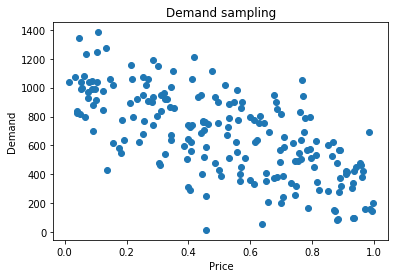

In [67]:
# Demand - Price generation

n = 200
cv = 0.3

a = np.random.uniform(low = 1000, high = 2000)
b = np.random.uniform(low = 500, high = 1000)
p = np.random.uniform(low = 0, high = 1, size = [n,1]) #~X

meanP = np.mean(p)
sigma = (a - b*meanP)*cv
D = np.repeat(-1, repeats = n)
for i in range(n):
    while D[i] < 0:
        D[i] = np.random.normal(loc = a - b * p[i], scale = sigma)
u = D - (a-b*p)
        

plt.plot(p,D,'o')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Demand sampling')


In [68]:
# Cost model
baseCostModel = gp.Model("Base Cost model")

#### Variables
betaC0 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ a
betaC1 = baseCostModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ b

inventory = {}
shortage = {}
sales = {}
for i in range(n):
    inventory[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = holdingCost)
    shortage[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = penaltyCost)
   
    sales[i] = baseCostModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)

#### Constraints
for i in range(n):
    baseCostModel.addConstr(shortage[i] == D[i] - sales[i])
    baseCostModel.addConstr(inventory[i] >= betaC0 + betaC1 * p[i] - D[i])
    baseCostModel.addConstr(sales[i] <= D[i])
    baseCostModel.addConstr(sales[i] <= betaC0 + betaC1 * p[i])
    
baseCostModel.optimize()


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 800 rows, 602 columns and 1800 nonzeros
Model fingerprint: 0xddccfbb3
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 400 rows and 200 columns
Presolve time: 0.01s
Presolved: 400 rows, 402 columns, 1200 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     233    7.4094718e+04   0.000000e+00   0.000000e+00      0s

Solved in 233 iterations and 0.01 seconds
Optimal objective  7.409471770e+04


**Results:**

Objective: 74094.717696979
Estimation of a 1312.760715744503
Estimation of b -672.9345822341204

Order quantity - price function: D =  1313.0 - 672.93 * p


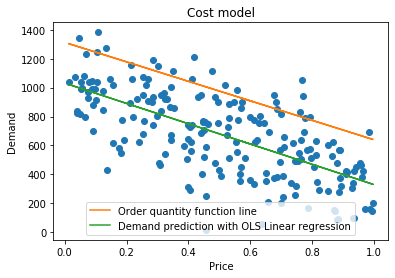

In [69]:
print("Objective: "+str(baseCostModel.objVal))
print('Estimation of a', betaC0.x)
print('Estimation of b', betaC1.x)

print('\nOrder quantity - price function: D = ', round(betaC0.x,0),'-', abs(round(betaC1.x,2)),'* p')


# OLS Linear regression for comparison
reg = linear_model.LinearRegression().fit(p, D)
coef2 = reg.coef_
coef1 = reg.intercept_

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaC0.x + betaC1.x*p, label='Order quantity function line')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Cost model')
plt.show()

In [70]:
# Service level model
baseSLModel = gp.Model("Base Service level model")

#### Variables
betaSL0 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ a
betaSL1 = baseSLModel.addVar(lb = - GRB.INFINITY, vtype = GRB.CONTINUOUS) # ~ b

inventory = {}
sales = {}
unfulfilled = {}
for i in range(n):
    inventory[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS, obj = holdingCost)   
    sales[i] = baseSLModel.addVar(lb = 0, vtype = GRB.CONTINUOUS)
    unfulfilled[i] = baseSLModel.addVar(vtype = GRB.BINARY)

#### Constraints
for i in range(n):
    baseSLModel.addConstr(inventory[i] >= betaSL0 + betaSL1 * p[i] - D[i])
    baseSLModel.addConstr(sales[i] <= D[i])
    baseSLModel.addConstr(sales[i] <= betaSL0 + betaSL1 * p[i])
    
    baseSLModel.addConstr(D[i] - unfulfilled[i]*np.max(D) <= betaSL0 + betaSL1 * p[i])

#non-stockout (alpha level)    
baseSLModel.addConstr(sum(unfulfilled[i] for i in range(n)) <= n*(1-nonStockOut)) 

#fillrate (beta level)
#baseSLModel.addConstr( sum(sales[i] for i in range(n)) >= fillRate * sum(D[i] for i in range(n)) )

baseSLModel.optimize()


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 801 rows, 602 columns and 2200 nonzeros
Model fingerprint: 0xa3eb356b
Variable types: 402 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 1e+03]
Found heuristic solution: objective 352166.77087
Presolve removed 200 rows and 200 columns
Presolve time: 0.00s
Presolved: 601 rows, 402 columns, 1800 nonzeros
Variable types: 202 continuous, 200 integer (200 binary)

Root relaxation: objective 1.091033e+04, 226 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 10910.3297    0  128 352166.771 10910.3297  96.9%     -    0s
H    0     0                    94920.637327 10910.3297  88.5%     -    0s
H    0     0                    71983.498949 1

**Results:**

Objective: 55261.05977099344
Estimation of a 1147.8259269066953
Estimation of b -414.5411179551846

Order quantity - price function: D =  1148.0 - 414.54 * p


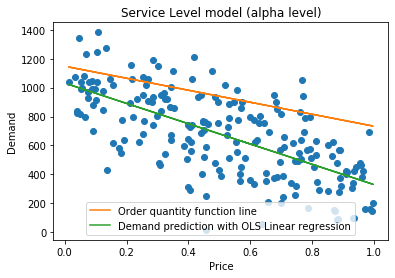

In [72]:
print("Objective: "+str(baseSLModel.objVal))
print('Estimation of a', betaSL0.x)
print('Estimation of b', betaSL1.x)

print('\nOrder quantity - price function: D = ', round(betaSL0.x,0),'-', abs(round(betaSL1.x,2)),'* p')


# OLS Linear regression for comparison
reg = linear_model.LinearRegression().fit(p, D)
coef2 = reg.coef_
coef1 = reg.intercept_

#Plot
plt.plot(p,D,'o')
plt.plot(p, betaSL0.x + betaSL1.x*p, label='Order quantity function line')
plt.plot(p, coef1 + coef2*p, label = 'Demand prediction with OLS Linear regression')
plt.legend(loc = 8)
plt.xlabel('Price')
plt.ylabel('Demand')
plt.title('Service Level model (alpha level)')
plt.show()

# PRICE SETTING

In [ ]:
#big M
M = 5000

m = gp.Model("Pricing Cost model")

#From previous problem
beta0 = 1590.987202508381 
beta1 = -686.2534613633845
sigma = 269.9480150447068
u = np.random.normal(loc = 0, scale = sigma, size = [periods,])

#### Variables
price = m.addVar(lb = 0, vtype = GRB.CONTINUOUS) 

quantity = m.addVar()
sales = {}
demand = {}
z = {} #binary variable = 1 if D = a - bp + u >= 0, =0 otherwise ==> to ensure demand not negative

for t in range(periods):
    sales[t] = m.addVar()
    demand[t] = m.addVar()
    z[t] = m.addVar(vtype = GRB.BINARY)

for t in range(periods):
    m.addConstr(demand[t] >= beta0 + beta1*price + u[t]) #demand[t] >= max(0, a-bp+u)
    m.addConstr(demand[t] <= beta0 + beta1*price + u[t] - (1-z[t])*M) #if z=1 or a-bp+u >= 0, constraint is bounded
    m.addConstr(M*z[t] >= beta0 + beta1*price + u[t] ) #if a-bp+u >= 0, z must equal to 1
    m.addConstr(sales[t] <= demand[t])
    m.addConstr(sales[t] <= quantity)

m.setObjective( sum(price*sales[t] for t in range(periods)) /periods - procurementcost*quantity)
m.modelSense = 0
    
m.Params.NonConvex = 2
m.optimize()

print("Objective: "+str(m.objVal))
print('Optimal price:',price.x)
print('Optima ordering quantity:', quantity.x)